In [69]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from keras.models import Sequential

from sklearn import set_config
# import sys
# sys.path.insert(0,'/Users/hagiwara/code/mohit-challa/GiveMeSomeCredit/notebooks/utils')
# from plots import plot_decision_regions

In [2]:
df = pd.read_csv('/Users/hagiwara/code/mohit-challa/GiveMeSomeCredit/raw_data/BankChurners.csv')
df.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)

In [3]:
df['Income_Category'].value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

## Exploring corelations with heatmap

<AxesSubplot:>

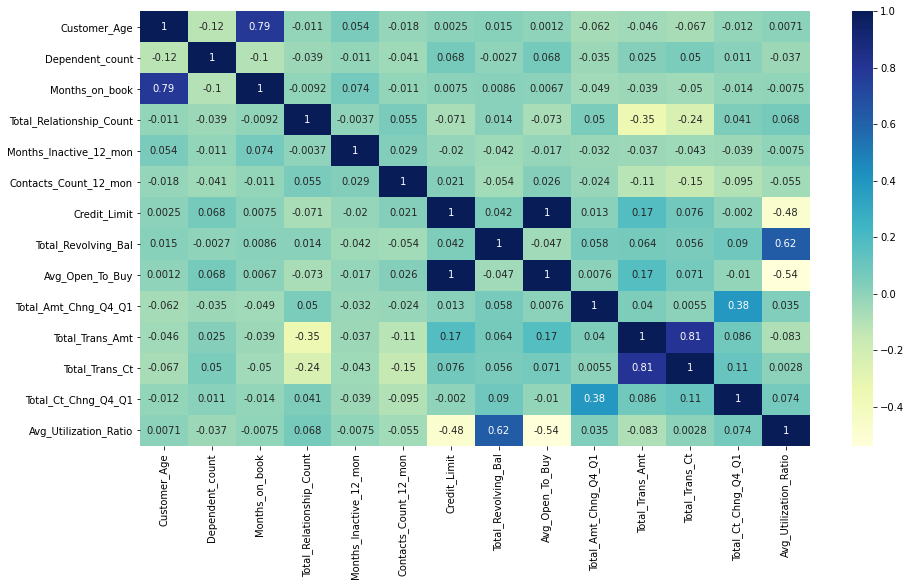

In [4]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(15,8)) 

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu",
        annot=True,
        ax=ax)

In [5]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation

In [6]:
corr_df.head()

,feature_1,feature_2,correlation
118,Avg_Open_To_Buy,Credit_Limit,0.995981
92,Credit_Limit,Avg_Open_To_Buy,0.995981
151,Total_Trans_Amt,Total_Trans_Ct,0.807192
164,Total_Trans_Ct,Total_Trans_Amt,0.807192
28,Months_on_book,Customer_Age,0.788912


Dropping the `Avg_Open_To_Buy` column because of high corelation with `Credit_Limit`

In [7]:
df.drop('Avg_Open_To_Buy',axis=1, inplace=True)

## Hold-out

In [8]:
X = df.drop('Attrition_Flag', axis=1)
y = df[['Attrition_Flag']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [9]:
y_train.value_counts()

Attrition_Flag   
Existing Customer    5917
Attrited Customer    1171
dtype: int64

## Pre-processing function

In [10]:
def preprocessing(X1,y1):
    
    X=X1.copy()
    y=y1.copy()
    #Encodingg gender
    onehot_encoder = OneHotEncoder(sparse=False)
    #onehot_encoder.fit(X[['Gender']])
    #X['Male'] = onehot_encoder.transform(X[['Gender']])
  
    gender_dict = {'M':1 , 'F':0}
    X['Male'] = X['Gender'].map(gender_dict)
    X.drop(['Gender'], axis=1, inplace=True)

    

    #Encodingg marital status
    onehot_encoder.fit(X[['Marital_Status']])
    X['Status_Divorced'], X['Status_Married'], X['Status_Single'], X['Status_Unknown'] = onehot_encoder.transform(X[['Marital_Status']]).T
    X.drop(['Marital_Status'], axis=1, inplace=True)
    
    #Mapping educational_level
    edu_dict = {'Unknown':2.5, 'Uneducated':0, 'High School':1, 'College':2, 'Graduate':3, 'Post-Graduate':4, 'Doctorate':5}
    X['Education_Level'] = X['Education_Level'].map(edu_dict)
    
    #Mapping income_category
    income_dict = {'Unknown':2 , 'Less than $40K':0, '$40K - $60K':1, '$60K - $80K':2, '$80K - $120K':3, '$120K +':4}
    X['Income_Category'] = X['Income_Category'].map(income_dict)
    
    #Mapping card_category
    card_dict = {'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3}
    X['Card_Category'] = X['Card_Category'].map(card_dict)
    
    #Scaling
    std_scaler = StandardScaler()
    std_scaler.fit(X)
    X_scaled = pd.DataFrame(std_scaler.transform(X))
    X = pd.DataFrame(data=X_scaled.values, columns=X.columns)
    
    #Encoding Attrition_flag
    #onehot_encoder.fit(y[['Attrition_Flag']])
    #y['Existing Customer'] = onehot_encoder.transform(y[['Attrition_Flag']])
    #y.drop('Attrition_Flag', axis=1, inplace=True)

    y_dict = {'Existing Customer':1, 'Attrited Customer':0}
    y['Existing Customer'] = y['Attrition_Flag'].map(y_dict)
    y.drop(['Attrition_Flag'], axis=1, inplace=True)

    
    return X, y

In [11]:
y_train.head()

,Attrition_Flag
4813,Existing Customer
9887,Existing Customer
4191,Existing Customer
7527,Existing Customer
5081,Existing Customer


In [12]:
X_train_proc, y_train_proc = preprocessing(X_train, y_train)
#X_test, y_test = preprocessing(X_test, y_test)

## Handling class imbalance using SMOTE

In [13]:
print('Before handling imbalance:\n', y_train_proc.value_counts())
oversample = SMOTE(random_state=0)
X_train_resample, y_train_resample = oversample.fit_resample(X_train_proc, y_train_proc)
y_train_final = pd.DataFrame(y_train_resample)
X_train_final = pd.DataFrame(X_train_resample,columns = X_train_proc.columns)
print('\nAfter handling imbalance:\n', y_train_final.value_counts())

Before handling imbalance:
 Existing Customer
1                    5917
0                    1171
dtype: int64

After handling imbalance:
 Existing Customer
0                    5917
1                    5917
dtype: int64


In [14]:
X_train_final.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Male,Status_Divorced,Status_Married,Status_Single,Status_Unknown
0,0.070596,-0.268854,0.652245,1.218339,-0.246191,0.503428,1.414525,-1.323300,0.486704,0.890409,...,-0.536527,-0.229879,-0.370894,-0.821786,-0.726172,1.058419,3.546624,-0.931779,-0.800937,-0.276084
1,0.949128,-1.040993,0.271397,0.447717,-0.246191,1.512241,0.127801,2.625985,1.383209,-0.428937,...,0.555353,3.313302,1.634726,0.010678,-0.050252,1.058419,-0.281958,-0.931779,1.248537,-0.276084
2,-0.682431,1.275424,-1.632842,-1.093526,-0.246191,-0.379283,0.771163,-0.335979,0.486704,-0.634064,...,0.771925,0.094497,0.525234,1.277828,0.040598,-0.944805,-0.281958,1.073215,-0.800937,-0.276084
3,0.196101,0.503285,0.652245,0.447717,-0.246191,0.377326,-0.515561,-1.323300,-0.409802,-0.277293,...,-0.820776,-0.037308,-0.072185,-0.231269,0.040598,-0.944805,-0.281958,1.073215,-0.800937,-0.276084
4,0.321605,1.275424,-0.109451,1.988961,-0.246191,0.629530,-0.515561,-1.323300,-1.306308,-0.161304,...,-0.464336,-0.336732,-0.285549,1.171207,-0.380944,1.058419,3.546624,-0.931779,-0.800937,-0.276084


<AxesSubplot:>

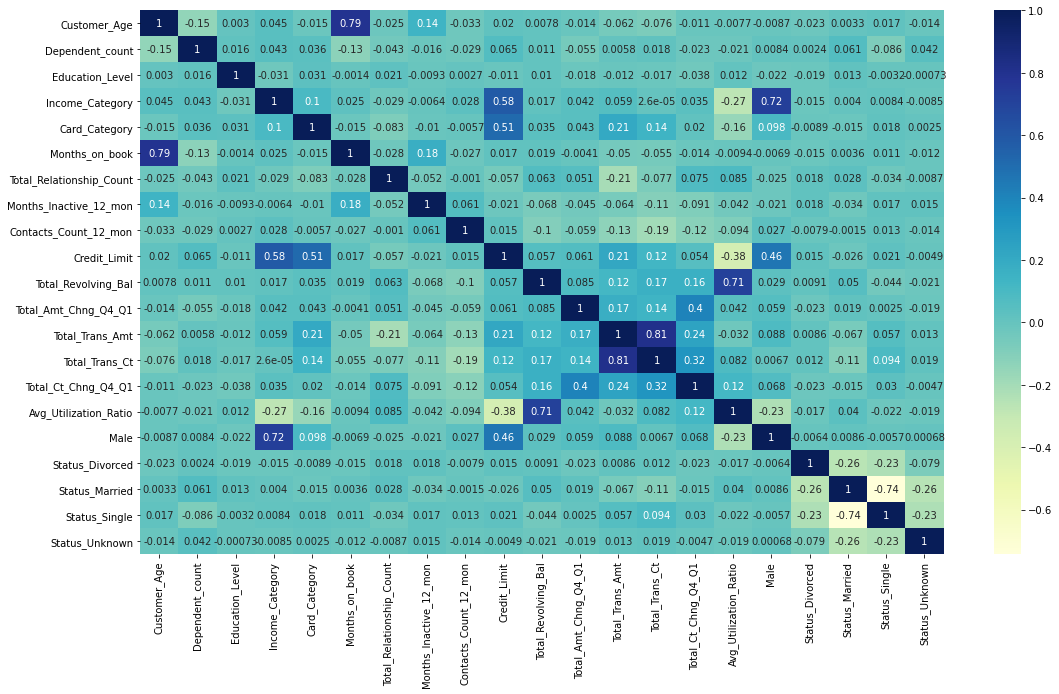

In [15]:
corr = X_train_final.corr()

fig, ax = plt.subplots(figsize=(18,10)) 

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu",
        annot=True,
        ax=ax)

In [16]:
corr_trained = corr.unstack().reset_index() # Unstack correlation matrix 
corr_trained.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_trained.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_trained = corr_trained[corr_trained['feature_1'] != corr_trained['feature_2']] # Remove self correlation

In [17]:
corr_trained.head()

,feature_1,feature_2,correlation
285,Total_Trans_Ct,Total_Trans_Amt,0.812067
265,Total_Trans_Amt,Total_Trans_Ct,0.812067
105,Months_on_book,Customer_Age,0.792208
5,Customer_Age,Months_on_book,0.792208
339,Male,Income_Category,0.721377


### Pre-processing the test set

In [18]:
#X_val, y_val = X_test,y_test

In [19]:
X_val, y_val=preprocessing(X_test,y_test)

In [20]:
X_val

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Male,Status_Divorced,Status_Married,Status_Single,Status_Unknown
0,-0.254328,2.033201,-1.595343,0.459527,-0.260953,0.401467,0.747254,-0.34141,-2.260721,0.818781,...,0.070275,-0.238980,-0.265287,0.874582,-0.649302,1.063549,3.528017,-0.919942,-0.792854,-0.297434
1,-0.254328,0.503581,0.314920,0.459527,-0.260953,-0.214911,-1.183240,0.65336,0.506227,1.917327,...,1.312095,1.322820,-0.222831,-0.755373,-1.010607,-0.940248,-0.283445,-0.919942,1.261266,-0.297434
2,-1.116117,0.503581,-0.831238,-1.087845,-0.260953,-1.201114,-0.539742,-1.33618,-0.416089,-0.624056,...,0.234289,0.026555,0.074365,-0.974189,1.735308,-0.940248,-0.283445,-0.919942,1.261266,-0.297434
3,-1.485455,-1.026038,0.696973,-0.314159,-0.260953,0.031640,1.390751,-0.34141,0.506227,-0.534078,...,1.283979,-0.757901,-1.369158,2.200874,0.232281,1.063549,-0.283445,1.087025,-0.792854,-0.297434
4,0.607461,1.268391,-0.831238,-1.087845,-0.260953,-0.338186,-1.183240,1.64813,0.506227,-0.607447,...,0.440478,0.322912,0.244192,1.182710,1.428199,-0.940248,-0.283445,-0.919942,1.261266,-0.297434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034,0.730574,1.268391,-0.831238,0.459527,-0.260953,0.031640,1.390751,0.65336,-0.416089,-0.659256,...,-0.234323,0.178586,0.626301,0.316378,1.410134,1.063549,-0.283445,-0.919942,-0.792854,3.362089
3035,-0.377440,1.268391,0.696973,-1.087845,-0.260953,-0.091635,-0.539742,0.65336,-2.260721,-0.235655,...,-0.679504,0.922145,0.965953,-0.344535,-0.190445,-0.940248,-0.283445,1.087025,-0.792854,-0.297434
3036,1.592363,-1.026038,-0.831238,0.459527,-0.260953,2.004048,-1.183240,-1.33618,-1.338405,-0.127967,...,-0.276498,0.059747,1.093323,0.503934,0.167246,-0.940248,-0.283445,-0.919942,1.261266,-0.297434
3037,-0.254328,-1.026038,0.696973,0.459527,-0.260953,0.154916,-0.539742,-1.33618,1.428542,0.896330,...,-1.232465,-0.124587,0.159278,-0.621404,-0.746854,1.063549,-0.283445,-0.919942,1.261266,-0.297434


## Logistic Regression: Cross Validation

In [21]:
log_model = LogisticRegression()
log_model.fit(X_train_final,y_train_final)

LogisticRegression()

In [22]:
log_cv_results = cross_validate(log_model, X_val, y_val, cv=10, 
                            scoring=['accuracy','recall','precision','f1'])

In [23]:
print('Accuracy:\n', log_cv_results['test_accuracy'].mean())
print('\nRecall\n', log_cv_results['test_recall'].mean())
print('\nPrecision\n', log_cv_results['test_precision'].mean())
print('\nf1:\n', log_cv_results['test_f1'].mean())

Accuracy:
 0.900954273058885

Recall
 0.964379994612553

Precision
 0.9229008248484545

f1:
 0.9430532107259164


## KNN Classifier

In [24]:
knn_model = KNeighborsClassifier(n_neighbors=3, p=1)
knn_model.fit(X_train_final,y_train_final)

KNeighborsClassifier(n_neighbors=3, p=1)

In [25]:
knn_cv_results = cross_validate(knn_model, X_val, y_val, cv=10, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [26]:
print('Accuracy:\n', knn_cv_results['test_accuracy'].mean())
print('\nRecall:\n', knn_cv_results['test_recall'].mean())
print('\nPrecision:\n', knn_cv_results['test_precision'].mean())
print('\nf1:\n', knn_cv_results['test_f1'].mean())

Accuracy:
 0.9012723640785131

Recall:
 0.9721199604920535

Precision:
 0.9168057778361316

f1:
 0.9435941270096182


#### Grid searching the KNN model

Cell converted to markdown after getting the `best_params`

knn_model = KNeighborsClassifier()

k_grid = {'n_neighbors' : [2,3,4,5], 'p': [1,2,3]}

knn_grid = GridSearchCV(knn_model, k_grid, n_jobs=-1,  cv = 10)

knn_grid.fit(X_train, y_train)

`best_params`: {'n_neighbors': 3, 'p': 1}

Update `knn_cv_results` with the best params.

## SVM

In [27]:
svm_model = SVC(C=100, kernel='poly', probability=True)
svm_model.fit(X_train_final, y_train_final)

SVC(C=100, kernel='poly', probability=True)

In [28]:
svm_cv_results = cross_validate(svm_model, X_val, y_val, cv=5, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [29]:
print('Accuracy:\n', svm_cv_results['test_accuracy'].mean())
print('\nRecall:\n', svm_cv_results['test_recall'].mean())
print('\nPrecision:\n', svm_cv_results['test_precision'].mean())
print('\nf1:\n', svm_cv_results['test_f1'].mean())

Accuracy:
 0.8749539365299576

Recall:
 0.9179209212361117

Precision:
 0.9338946075625794

f1:
 0.9257629834965589


#### Grid searching the SVM model

Cell converted to markdown after getting the `best_params`

svm_model = SVC()

s_grid = {'kernel' : ['linear', 'poly', 'sigmoid'], 'C': [1,10,100]}

svm_grid = GridSearchCV(svm_model, s_grid, n_jobs=-1,  cv = 10)

svm_grid.fit(X_train, y_train)

`best_params`: {'C': 100, 'kernel': 'poly'}

## Random Forest

In [30]:
rf_model = RandomForestClassifier(criterion='entropy', min_samples_split=2, n_estimators=500)
rf_model.fit(X_train_final, y_train_final)

RandomForestClassifier(criterion='entropy', n_estimators=500)

In [31]:
rf_cv_results = cross_validate(rf_model, X_val, y_val, cv=5, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [32]:
print('Accuracy:\n', rf_cv_results['test_accuracy'].mean())
print('\nRecall:\n', rf_cv_results['test_recall'].mean())
print('\nPrecision:\n', rf_cv_results['test_precision'].mean())
print('\nf1:\n', rf_cv_results['test_f1'].mean())

Accuracy:
 0.9489969001994277

Recall:
 0.9891592820835771

Precision:
 0.9527602562176414

f1:
 0.9705833400347881


#### Grid searching the RF model

Cell converted to markdown after getting the `best_params`

rf_model = RandomForestClassifier()

r_grid = {'n_estimators': [100, 200, 500], 'criterion':["gini", "entropy"], 'min_samples_split':[2,3,4]}

rf_grid = GridSearchCV(rf_model, r_grid, n_jobs=-1, cv = 5)

rf_grid.fit(X_train, y_train)

`best_params`: {'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 500}

## Inspecting AUC scores to select the best model

In [33]:
log_auc_score = roc_auc_score(y_val, log_model.predict_proba(X_val)[:,1], multi_class='ovr')
knn_auc_score = roc_auc_score(y_val, knn_model.predict_proba(X_val)[:,1], multi_class='ovr')
svm_auc_score = roc_auc_score(y_val, svm_model.predict_proba(X_val)[:,1], multi_class='ovr')
rf_auc_score = roc_auc_score(y_val, rf_model.predict_proba(X_val)[:,1], multi_class='ovr')

print(log_auc_score)
print(knn_auc_score)
print(svm_auc_score)
print(rf_auc_score)

0.9243679999456635
0.8814541434888034
0.9104876011166126
0.9804673438338394


Text(0.5, 1.0, 'Precision-Recall curves')

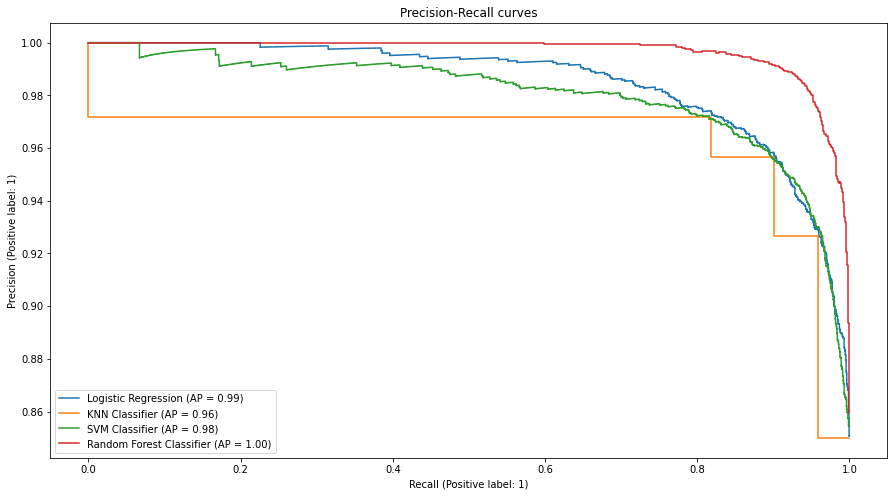

In [34]:
fig = plt.gcf()
fig.set_size_inches(15, 8)

plot_precision_recall_curve(log_model, X_val, y_val, ax = plt.gca(),name = 'Logistic Regression')
plot_precision_recall_curve(knn_model, X_val, y_val, ax = plt.gca(),name = 'KNN Classifier')
plot_precision_recall_curve(svm_model, X_val, y_val, ax = plt.gca(),name = 'SVM Classifier')
plot_precision_recall_curve(rf_model, X_val, y_val, ax = plt.gca(),name = 'Random Forest Classifier')

plt.title('Precision-Recall curves')

### From precision-recall curves, Random Forest classifier is the best model for the given task.

## Threshold Adjustment
Finding the decision threshold that guarantees a 95% precision for predicting customer attrition.

In [35]:
# Predict probabilities
y_pred_probas_0, y_pred_probas_1 = cross_val_predict(rf_model,
                                                     X_val, np.array(y_val).flatten(),
                                                     method = "predict_proba").T

# Generate precision and thresholds (and recalls) using probabilities for class 1
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_probas_1)

# Populate dataframe with precision and threshold
df_precision = pd.DataFrame({"precision" : precision[:-1], "threshold" : thresholds})

# Find out which threshold guarantees a precision of 0.95
new_threshold = df_precision[df_precision['precision'] >= 0.95]['threshold'].min()

new_threshold

0.496

## Deep Learning Test 1

In [36]:
''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualisation'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import metrics

In [37]:
metrics = [
    keras.metrics.Recall(),
    keras.metrics.Precision(),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

In [38]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.metrics import Recall, Precision

def init_model():
    input_shape = X_train_final.shape[1:]
    #normalizer = Normalization()
    #normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(layers.Dense(21, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    optimizer = Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [39]:
model = init_model()
#model.summary()

In [40]:
es = EarlyStopping(
    patience=10,
    monitor='val_recall', # We really want to detect fraudulent transactions!
    restore_best_weights=True)

history = model.fit(X_train_final, y_train_final,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=64, # Large enough to get a decent chance of conatining fraudulent transactions 
                    callbacks=[es], shuffle=True)

Epoch 1/100
185/185 [==============================] - 4s 7ms/step - loss: 0.8960 - recall: 0.6870 - precision: 0.4945 - prc: 0.5354 - val_loss: 0.5774 - val_recall: 0.7967 - val_precision: 0.8550 - val_prc: 0.8827
Epoch 2/100
185/185 [==============================] - 0s 3ms/step - loss: 0.8031 - recall: 0.6564 - precision: 0.5113 - prc: 0.5608 - val_loss: 0.5847 - val_recall: 0.7774 - val_precision: 0.8749 - val_prc: 0.9030
Epoch 3/100
185/185 [==============================] - 0s 3ms/step - loss: 0.7452 - recall: 0.6353 - precision: 0.5277 - prc: 0.5880 - val_loss: 0.5898 - val_recall: 0.7545 - val_precision: 0.8920 - val_prc: 0.9167
Epoch 4/100
185/185 [==============================] - 1s 3ms/step - loss: 0.7109 - recall: 0.6378 - precision: 0.5471 - prc: 0.6161 - val_loss: 0.5854 - val_recall: 0.7480 - val_precision: 0.9024 - val_prc: 0.9272
Epoch 5/100
185/185 [==============================] - 1s 3ms/step - loss: 0.6858 - recall: 0.6468 - precision: 0.5643 - prc: 0.6452 - val_l

In [41]:
def plot_history(history, metric):
    plt.plot(history.history[f'{metric}'])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.ylabel(f'{metric}')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

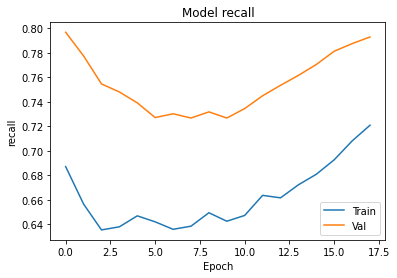

In [42]:
plot_history(history, "recall")

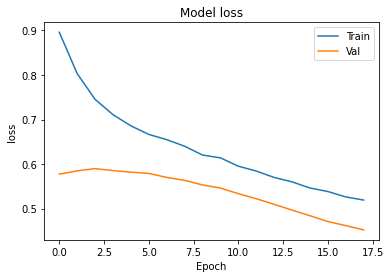

In [43]:
plot_history(history, "loss")

In [44]:
model.evaluate(X_val, y_val, verbose=0, return_dict=True)

{'loss': 0.5633980631828308,
 'recall': 0.7266744375228882,
 'precision': 0.9324391484260559,
 'prc': 0.9501169323921204}

In [45]:
X_val

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Male,Status_Divorced,Status_Married,Status_Single,Status_Unknown
0,-0.254328,2.033201,-1.595343,0.459527,-0.260953,0.401467,0.747254,-0.34141,-2.260721,0.818781,...,0.070275,-0.238980,-0.265287,0.874582,-0.649302,1.063549,3.528017,-0.919942,-0.792854,-0.297434
1,-0.254328,0.503581,0.314920,0.459527,-0.260953,-0.214911,-1.183240,0.65336,0.506227,1.917327,...,1.312095,1.322820,-0.222831,-0.755373,-1.010607,-0.940248,-0.283445,-0.919942,1.261266,-0.297434
2,-1.116117,0.503581,-0.831238,-1.087845,-0.260953,-1.201114,-0.539742,-1.33618,-0.416089,-0.624056,...,0.234289,0.026555,0.074365,-0.974189,1.735308,-0.940248,-0.283445,-0.919942,1.261266,-0.297434
3,-1.485455,-1.026038,0.696973,-0.314159,-0.260953,0.031640,1.390751,-0.34141,0.506227,-0.534078,...,1.283979,-0.757901,-1.369158,2.200874,0.232281,1.063549,-0.283445,1.087025,-0.792854,-0.297434
4,0.607461,1.268391,-0.831238,-1.087845,-0.260953,-0.338186,-1.183240,1.64813,0.506227,-0.607447,...,0.440478,0.322912,0.244192,1.182710,1.428199,-0.940248,-0.283445,-0.919942,1.261266,-0.297434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034,0.730574,1.268391,-0.831238,0.459527,-0.260953,0.031640,1.390751,0.65336,-0.416089,-0.659256,...,-0.234323,0.178586,0.626301,0.316378,1.410134,1.063549,-0.283445,-0.919942,-0.792854,3.362089
3035,-0.377440,1.268391,0.696973,-1.087845,-0.260953,-0.091635,-0.539742,0.65336,-2.260721,-0.235655,...,-0.679504,0.922145,0.965953,-0.344535,-0.190445,-0.940248,-0.283445,1.087025,-0.792854,-0.297434
3036,1.592363,-1.026038,-0.831238,0.459527,-0.260953,2.004048,-1.183240,-1.33618,-1.338405,-0.127967,...,-0.276498,0.059747,1.093323,0.503934,0.167246,-0.940248,-0.283445,-0.919942,1.261266,-0.297434
3037,-0.254328,-1.026038,0.696973,0.459527,-0.260953,0.154916,-0.539742,-1.33618,1.428542,0.896330,...,-1.232465,-0.124587,0.159278,-0.621404,-0.746854,1.063549,-0.283445,-0.919942,1.261266,-0.297434


## Deep learning test 3


In [46]:
model3 = keras.Sequential([
  keras.layers.Flatten(input_shape=(21,)),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid'),
  ])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 21)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                352       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [47]:
es_3 = EarlyStopping(
    patience=10, 
    monitor = 'prc',
    restore_best_weights=True)

metrics = [
    keras.metrics.Recall(),
    keras.metrics.Precision(),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

In [48]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

model3.fit(X_train_final, y_train_final, epochs=50, batch_size=16, callbacks=[es_3])
model3.evaluate(X_val, y_val)

Epoch 1/50
740/740 [==============================] - 3s 2ms/step - loss: 0.4041 - recall: 0.7571 - precision: 0.8675 - prc: 0.9067
Epoch 2/50
740/740 [==============================] - 1s 2ms/step - loss: 0.2687 - recall: 0.8900 - precision: 0.8865 - prc: 0.9595
Epoch 3/50
740/740 [==============================] - 1s 2ms/step - loss: 0.2262 - recall: 0.9042 - precision: 0.9083 - prc: 0.9718
Epoch 4/50
740/740 [==============================] - 1s 2ms/step - loss: 0.2018 - recall: 0.9113 - precision: 0.9261 - prc: 0.9774
Epoch 5/50
740/740 [==============================] - 1s 2ms/step - loss: 0.1884 - recall: 0.9177 - precision: 0.9327 - prc: 0.9801
Epoch 6/50
740/740 [==============================] - 1s 2ms/step - loss: 0.1782 - recall: 0.9204 - precision: 0.9377 - prc: 0.9822
Epoch 7/50
740/740 [==============================] - 1s 2ms/step - loss: 0.1722 - recall: 0.9214 - precision: 0.9402 - prc: 0.9833
Epoch 8/50
740/740 [==============================] - 1s 2ms/step - loss: 0.

[0.3199619650840759,
 0.8757259249687195,
 0.9646055698394775,
 0.9858473539352417]

In [49]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

model3.fit(X_train_final, y_train_final, epochs=50, batch_size=16, callbacks=[es_3])
model3.evaluate(X_val, y_val)#prc

Epoch 1/50
740/740 [==============================] - 3s 2ms/step - loss: 0.2711 - recall: 0.8867 - precision: 0.9058 - prc: 0.9647
Epoch 2/50
740/740 [==============================] - 1s 2ms/step - loss: 0.2295 - recall: 0.9047 - precision: 0.9088 - prc: 0.9707
Epoch 3/50
740/740 [==============================] - 1s 2ms/step - loss: 0.2045 - recall: 0.9136 - precision: 0.9222 - prc: 0.9767
Epoch 4/50
740/740 [==============================] - 1s 2ms/step - loss: 0.1900 - recall: 0.9172 - precision: 0.9275 - prc: 0.9798
Epoch 5/50
740/740 [==============================] - 1s 2ms/step - loss: 0.1806 - recall: 0.9187 - precision: 0.9363 - prc: 0.9817
Epoch 6/50
740/740 [==============================] - 1s 2ms/step - loss: 0.1739 - recall: 0.9238 - precision: 0.9376 - prc: 0.9827
Epoch 7/50
740/740 [==============================] - 1s 2ms/step - loss: 0.1682 - recall: 0.9267 - precision: 0.9429 - prc: 0.9837
Epoch 8/50
740/740 [==============================] - 2s 2ms/step - loss: 0.

[0.2869777977466583, 0.8834688067436218, 0.971477210521698, 0.9895849823951721]

In [50]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

model3.fit(X_train_final, y_train_final, epochs=50, batch_size=16, callbacks=[es_3])
model3.evaluate(X_val, y_val)

Epoch 1/50
740/740 [==============================] - 3s 2ms/step - loss: 0.2303 - recall: 0.8980 - precision: 0.9252 - prc: 0.9746
Epoch 2/50
740/740 [==============================] - 2s 2ms/step - loss: 0.2056 - recall: 0.9126 - precision: 0.9207 - prc: 0.9763
Epoch 3/50
740/740 [==============================] - 3s 3ms/step - loss: 0.1909 - recall: 0.9180 - precision: 0.9305 - prc: 0.9795
Epoch 4/50
740/740 [==============================] - 2s 2ms/step - loss: 0.1810 - recall: 0.9216 - precision: 0.9350 - prc: 0.9816: 0s - loss: 0.1822 - recall: 0.9229 - precision: 0.93
Epoch 5/50
740/740 [==============================] - 1s 2ms/step - loss: 0.1742 - recall: 0.9219 - precision: 0.9389 - prc: 0.9829
Epoch 6/50
740/740 [==============================] - 1s 2ms/step - loss: 0.1684 - recall: 0.9251 - precision: 0.9417 - prc: 0.9840
Epoch 7/50
740/740 [==============================] - 1s 2ms/step - loss: 0.1642 - recall: 0.9250 - precision: 0.9451 - prc: 0.9846
Epoch 8/50
740/740 [==

[0.29542139172554016,
 0.876887321472168,
 0.9775571823120117,
 0.9911364912986755]

## Features Correlation

In [51]:
Xcorpro, ycorpro=preprocessing(X,y)

In [52]:
dfcor=Xcorpro+ycorpro

In [53]:
Xcorpro=Xcorpro[['Income_Category','Education_Level', 'Months_on_book']]

In [54]:
Xcorpro['Existing Customer'] = ycorpro['Existing Customer']


In [55]:
Xcorpro

,Income_Category,Education_Level,Months_on_book,Existing Customer
0,0.451246,-0.859032,0.384621,1
1,-1.091813,0.665510,1.010715,1
2,1.222775,0.665510,0.008965,1
3,-1.091813,-0.859032,-0.241473,1
4,0.451246,-1.621303,-1.869317,1
...,...,...,...,...
10122,-0.320283,0.665510,0.509840,1
10123,-0.320283,0.284375,-1.368442,0
10124,-1.091813,-0.859032,0.008965,0
10125,-0.320283,0.665510,0.008965,0


<AxesSubplot:>

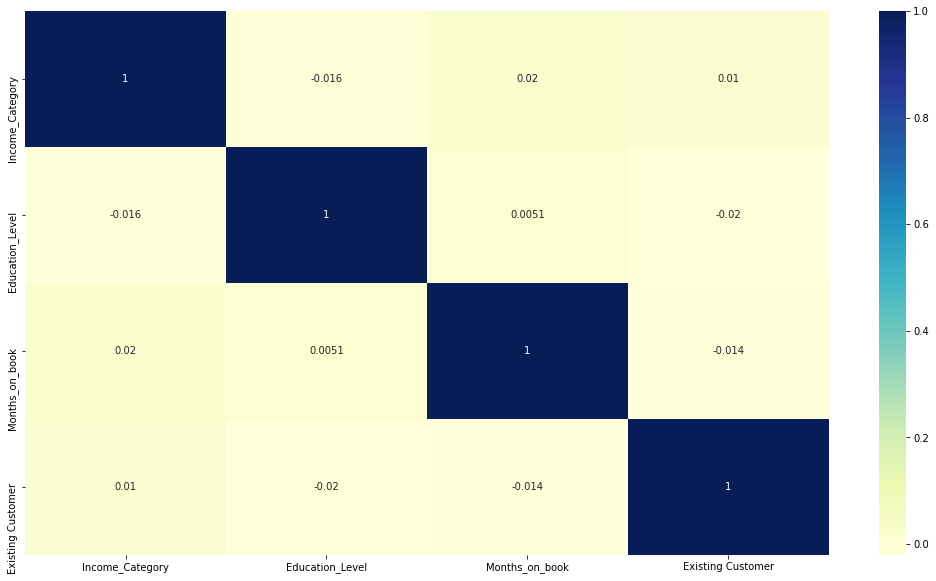

In [56]:
corr = Xcorpro.corr()

fig, ax = plt.subplots(figsize=(18,10)) 

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu",
        annot=True,
        ax=ax)

In [57]:
df

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,0.703,15476,117,0.857,0.462
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,0.804,8764,69,0.683,0.511
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,0.819,10291,60,0.818,0.000
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,0.535,8395,62,0.722,0.000


In [58]:
X_train_final3 = X_train_final
X_train_final3['Existing Customer'] = ycorpro['Existing Customer']

<AxesSubplot:>

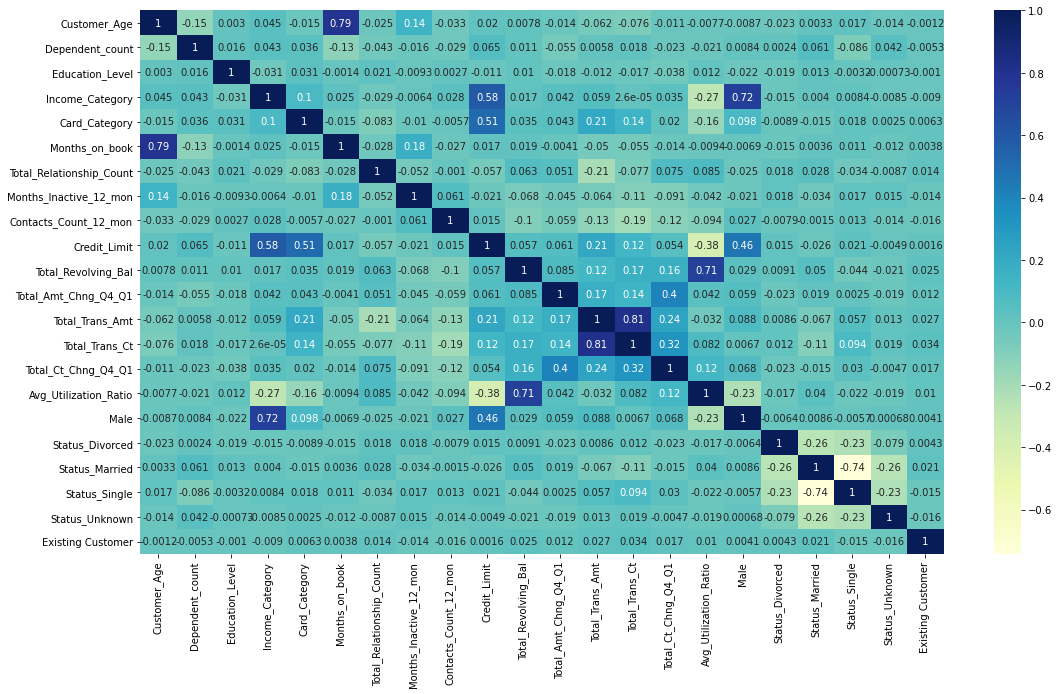

In [59]:
corr = X_train_final3.corr()

fig, ax = plt.subplots(figsize=(18,10)) 

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu",
        annot=True,
        ax=ax)

## PFI

In [60]:
print(__doc__)
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

 Tensorflow Keras


In [61]:
df.head(5)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,2.175,816,28,2.500,0.000


In [62]:
Xpfi = df.drop(columns='Attrition_Flag')
ypfi = df['Attrition_Flag']

In [63]:
X_trainpfi, X_testpfi, y_trainpfi, y_testpfi = train_test_split(
    Xpfi, ypfi, stratify=ypfi, random_state=42)

In [64]:
#rng = np.random.RandomState(seed=42)
#X['random_cat'] = rng.randint(3, size=X.shape[0])
#X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['Gender', 'Education_Level', 'Marital_Status','Income_Category',
                      'Card_Category']
numerical_columns = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
                     'Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal',
                    'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1',
                    'Avg_Utilization_Ratio']

Xpfi = Xpfi[categorical_columns + numerical_columns]

In [65]:
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_trainpfi, y_trainpfi)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Education_Level',
                                                   'Marital_Status',
                                                   'Income_Category',
                                                   'Card_Category']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Customer_Age',
                                                   'Dependent_count',
                                                   'Months_on_book',
                                                   'Total_Relationship_Count',
                          

In [66]:
print("RF train accuracy: %0.3f" % rf.score(X_trainpfi, y_trainpfi))
print("RF test accuracy: %0.3f" % rf.score(X_testpfi, y_testpfi))

RF train accuracy: 1.000
RF test accuracy: 0.954


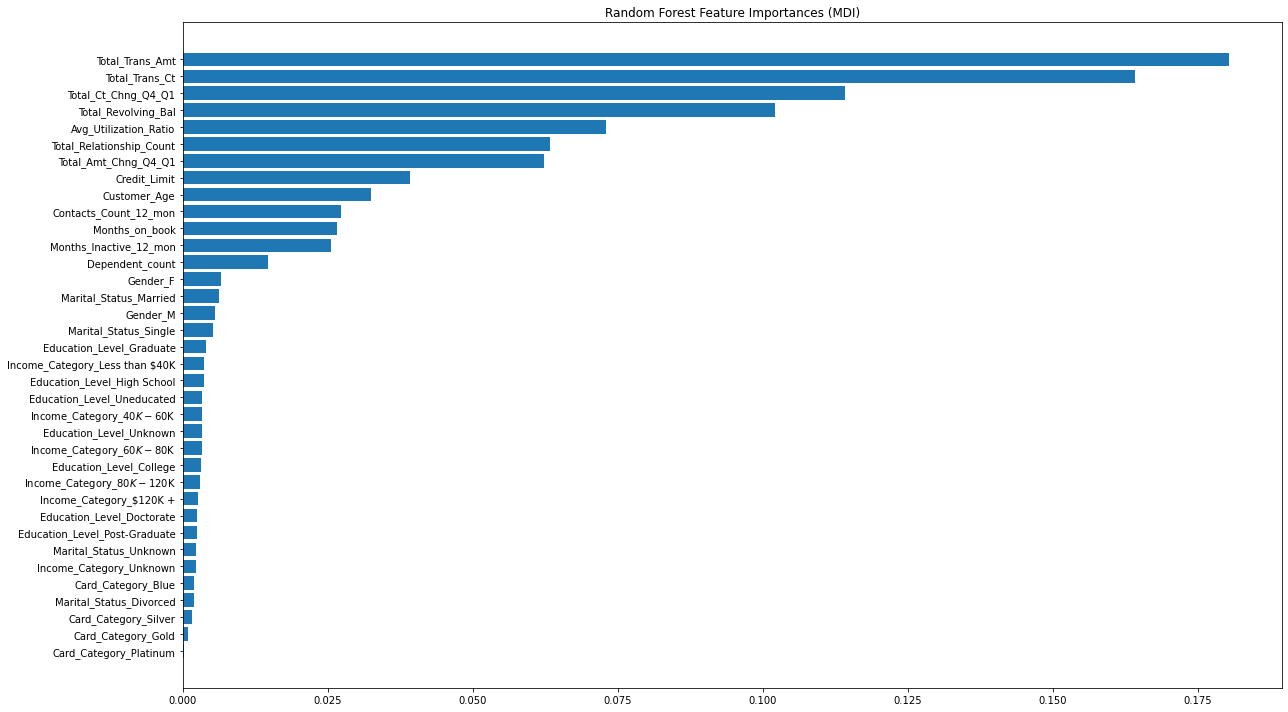

In [67]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(18,10)) 
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

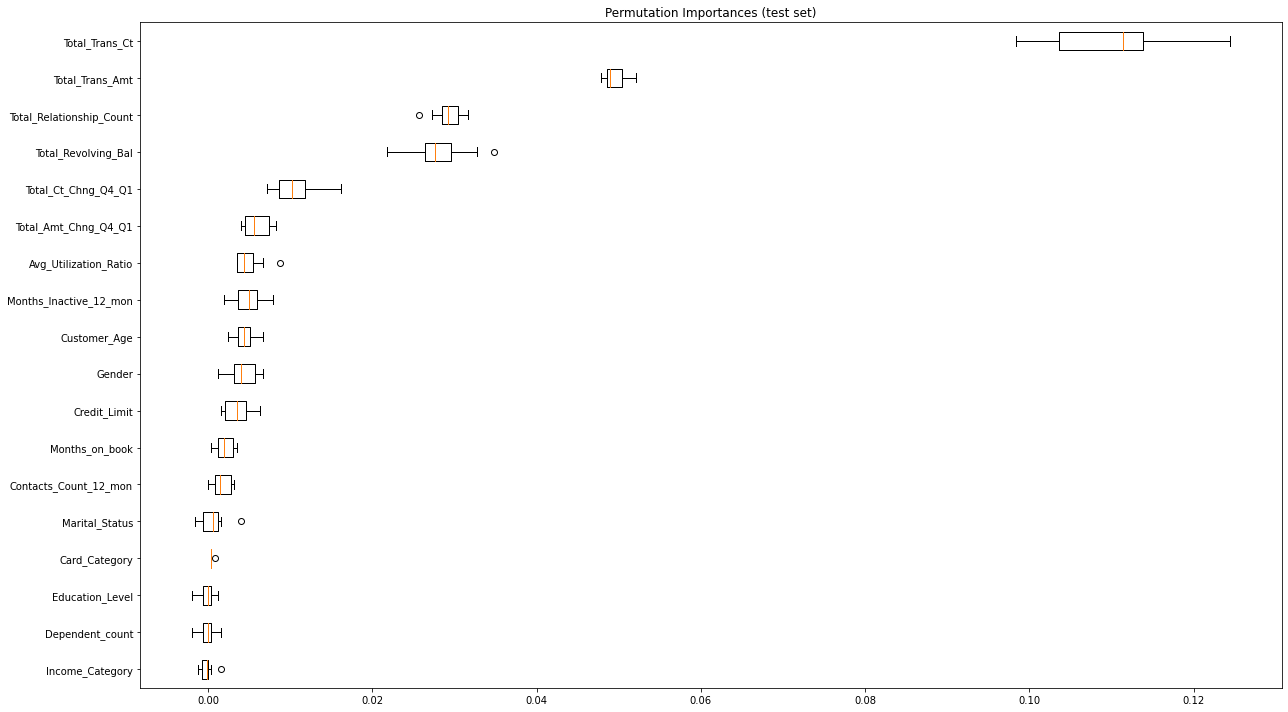

In [68]:
result = permutation_importance(rf, X_testpfi, y_testpfi, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(18,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_testpfi.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()